# GMM - 거리기반 K-Means의 문제점

GMM은 K-means가 가지는 문제점을 해결하기 위해 나왔다. 

오른쪽처럼 기하학적으로 길게 군집화하기 좋은 조건이 있음에도 불구하고 군집화가 안되어버린다. 

![](./img/GMM1.png)

<h2>GMM(Gaussian Mixture Model)개요</h2><br>

 

<img src="./img/GMM2.png"/>

<h2>서로 다른 정규 분포로 결합된 원본 데이터 분포</h2><br>

클러스터링 하려는 데이터 분포가 기본적으로 여러개의 정규분포로 구성되어있는 데이터 분포로 가정하는 것임

이렇게 가정한 상황에서 어떤 데이터분포가 정규분포 A, B, C에 속하는지 찾는 것임

<img src="./img/DifferentSTD1.png"/>



<h2>GMM 모수(Parameter) 추정</h2><br>

데이터 x가 정규분포 A에 속할 확률이 30%, B가 30%, C가 40%라면 <b>C</b>

<img src="./img/GMMParameter1.png"/>

<h2>GMM 모수 추정을 위한 EM(Expectation and Maximization)</h2><br>

EM 방법은 K-Means와 방법적으로는 매우 유사하다.(centroid로 연속적 계산하는 것처럼)

<img src="./img/EM1.png"/>

<h2>사이킷런 GaussianMixture</h2><br>

* 사이킷런은 GMM 군집화를 위해 GaussianMixture 클래스를 제공


* GaussianMixture 클래스의 주요 생성자 파라미터는 n_components 이며 이는 Mixture Model의 개수, 즉 군집화 개수를 의미

### GMM 을 이용한 붓꽃 데이터 셋 클러스터링

In [1]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

**GaussianMixture를 이용하여 붓꽃 데이터 군집화**

In [2]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 클러스터링 결과를 irisDF 의 'gmm_cluster' 컬럼명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels


# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인. 
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       1              45
        2               5
2       2              50
Name: gmm_cluster, dtype: int64


위 결과를 보면 0에는 50개 잘 할당, 1에 1과 2가 할당, 2가 5개 할당되었으므로 잘못할당된것으로 추정할 수 있음

긜고 2 값은 비교적 잘 할당 됨

K-Menas로 붓꽃 군집화 한것보다 더 잘 할당이 되었다.

**붓꽃 데이터 K-Means 군집화 결과**

In [3]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

0: 세토사 2: 버시칼라 3: 버지니카

In [4]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       2                 48
        0                  2
2       0                 36
        2                 14
Name: kmeans_cluster, dtype: int64


K-Means보다 GMM이 더 결과가 좋다. 이유는 붓꽃 데이터 자체가 두 종류는 약간 섞여있기 때문

**클러스터링 결과를 시각화하는 함수 생성**

이제 뭘 할거냐면 가우시안 믹스쳐에 맞는 길게 늘어선 데이터를 만들어서 데이터 세트 별로 K-Means는 어떻게 군집화를 시키는지, 가우시안 믹스쳐는 어떻게 군집화를 시키는지 클러스터링 할것임

In [5]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수
### 강의 8분 경 코드 설명 있음
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

**GMM군집화와 K-Means군집화를 비교하기 위해 타원형으로 늘어선 임의의 데이터 세트를 생성**

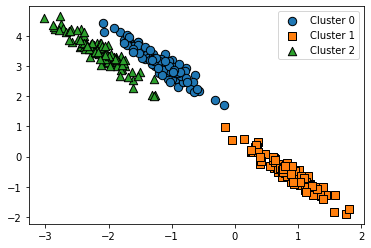

In [6]:
from sklearn.datasets import make_blobs

# make_blobs() 로 300개의 데이터 셋, 3개의 cluster 셋, cluster_std=0.5 을 만듬. 
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 셋을 생성하기 위해 변환함. 
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 셋과 make_blobs( ) 의 y 결과 값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
# 생성된 데이터 셋을 target 별로 다른 marker 로 표시하여 시각화 함. 
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)


위는 아직 클러스터 안했음. 실제값임. visualize_cluster_plot에 'target'넣어서 실제값부터 확인했다.

**K-Means 군집화 수행**

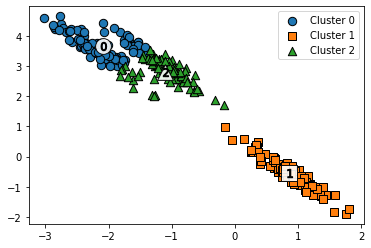

In [7]:
# 3개의 Cluster 기반 Kmeans 를 X_aniso 데이터 셋에 적용 
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label',iscenter=True)

**GMM 군집화 수행**

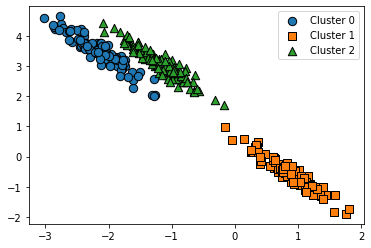

In [8]:
# 3개의 n_components기반 GMM을 X_aniso 데이터 셋에 적용 
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정. 
visualize_cluster_plot(gmm, clusterDF, 'gmm_label',iscenter=False)


**GMM과 K-Means 군집화 결과 비교**

In [9]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: kmeans_label, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: gmm_label, dtype: int64


K-Means는 1인 경우는 잘 됐다. 2인 경우는 86, 14로 쪼개졌고 0의 경우는 73, 27로 쪼개졌다. 

가우시안 믹스쳐는 아주 잘됐다.